# 🧠 Clasificador de Estado de Salud con PyTorch

Este proyecto utiliza una red neuronal profunda (MLP) implementada en PyTorch para clasificar el estado de salud de pacientes en tres categorías: **mala**, **regular** o **buena**, usando un conjunto de datos tabulares.

---


## Importar librerias

In [1]:
# Manejo de datos
import numpy as np
import pandas as pd
import random
import os

# Modelos de Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Gráficos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version torch: {torch.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")
print(f"{color}- Version sklearn: {pd.__version__}")

Versión de las librerias utilizadas:
- Version torch: 2.7.0+cpu
- Version pandas: 2.2.3
- Version numpy: 2.2.6
- Version sklearn: 2.2.3


## Lectura del dataset

In [2]:
try:
    data = pd.read_csv('Datasets\diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
    print("Archivo cargado correctamente.")
except Exception as e:
    print(f"Error: {e}")

Archivo cargado correctamente.


In [3]:
data.head(5)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

In [29]:
seed = 110425
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [6]:
x = data.drop(columns=["Diabetes_binary"]).to_numpy() # Datos de entrenamiento
y = data["Diabetes_binary"].to_numpy()
scaler = StandardScaler()
x = scaler.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [7]:
#Formato correcto
#Train
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

#Val
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

#Test
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [8]:
batchsize = 32
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = DiabetesDataset(X_train, y_train)
val_data = DiabetesDataset(X_val, y_val)
test_data = DiabetesDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=False)

In [9]:
len(train_data)

54079

In [10]:
#Definamos un modelo para trabajar
#Vamos a hacerlo más complejo de lo necesario

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hc1 = nn.Linear(21, 256)
        self.hc2 = nn.Linear(256, 128)
        self.hc3 = nn.Linear(128, 64)
        self.hc4 = nn.Linear(64, 2)
        #self.act = nn.ELU()
        self.act = nn.LeakyReLU()
        #self.act = nn.ReLU()
        self.dp1 = nn.Dropout(0.4)
        self.dp2 = nn.Dropout(0.2)

    def forward(self, input):
        l1 = self.dp1(self.act(self.hc1(input)))
        l2 = self.dp2(self.act(self.hc2(l1)))
        #l1 = self.act(self.hc1(input))
        #l2 = self.act(self.hc2(l1))
        l3 = self.act(self.hc3(l2))
        output = self.hc4(l3)
        return output

In [25]:
testeo = MLP()
#lr = 1e-4
#opt = torch.optim.Adam(testeo.parameters(), lr=lr, weight_decay=1e-4)
lr = 1e-4
opt = torch.optim.SGD(testeo.parameters(), lr=lr, weight_decay=1e-4)
# lr = 1e-4
# opt = torch.optim.RMSprop(testeo.parameters(), lr=lr, weight_decay=1e-4)
loss_func = nn.CrossEntropyLoss()

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)


In [20]:
lambda_l1 = 1e-3
def l1_penalty(model):
    l1 = 0.0
    for param in model.parameters():
        #l1 += param.abs().sum() #si cambiaramos abs() por pow(2.0) tendriamos L2
        if param.requires_grad and len(param.shape) > 1:
            l1 += torch.norm(param, p=1)
    return l1

In [26]:
#Entrenamiento
# lr = 1e-4
# opt = torch.optim.Adam(testeo.parameters(), lr=lr, weight_decay=1e-4)

n_epochs = 5000
history = {
    "TL" : [],
    "VL" : []
}
early_stopping = {
    "delta" : 1e-5,
    "patience": 50
}
best_val_loss = float("inf")
aux = 0

for i in range(n_epochs+1):
    testeo.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:  
      output = testeo(X_batch)
      loss = loss_func(output, y_batch)  #+ l1_penalty(testeo) *lambda_l1
      #scheduler.step(loss)
      
      opt.zero_grad()
      loss.backward()
      opt.step()

      epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    history["TL"].append(epoch_loss)

    testeo.eval()
    epoch_loss = 0
    for X_batch, y_batch in val_loader:
      with torch.no_grad():
        preds_val = testeo(X_batch)
      val_loss = loss_func(preds_val, y_batch)

      epoch_loss += val_loss.item()
    epoch_loss /= len(val_loader)
    history["VL"].append(epoch_loss)
    
    if epoch_loss + early_stopping["delta"] < best_val_loss:
      best_val_loss = epoch_loss
      aux = 0
      print(f"Reinicio aux en epoch {i}")
    else:
      aux += 1
      if aux >= early_stopping["patience"]:
        print(f"Terminando el entrenamiento en la época {i}")
        break
    

Reinicio aux en epoch 0
Reinicio aux en epoch 1
Reinicio aux en epoch 2
Reinicio aux en epoch 3
Reinicio aux en epoch 4
Reinicio aux en epoch 5
Reinicio aux en epoch 6
Reinicio aux en epoch 7
Reinicio aux en epoch 8
Reinicio aux en epoch 9
Reinicio aux en epoch 10
Reinicio aux en epoch 11
Reinicio aux en epoch 12
Reinicio aux en epoch 13
Reinicio aux en epoch 14
Reinicio aux en epoch 15
Reinicio aux en epoch 16
Reinicio aux en epoch 17
Reinicio aux en epoch 18
Reinicio aux en epoch 19
Reinicio aux en epoch 20
Reinicio aux en epoch 21
Reinicio aux en epoch 22
Reinicio aux en epoch 23
Reinicio aux en epoch 24
Reinicio aux en epoch 25
Reinicio aux en epoch 26
Reinicio aux en epoch 27
Reinicio aux en epoch 28
Reinicio aux en epoch 29
Reinicio aux en epoch 30
Reinicio aux en epoch 31
Reinicio aux en epoch 32
Reinicio aux en epoch 33
Reinicio aux en epoch 34
Reinicio aux en epoch 35
Reinicio aux en epoch 36
Reinicio aux en epoch 37
Reinicio aux en epoch 38
Reinicio aux en epoch 39
Reinicio a

KeyboardInterrupt: 

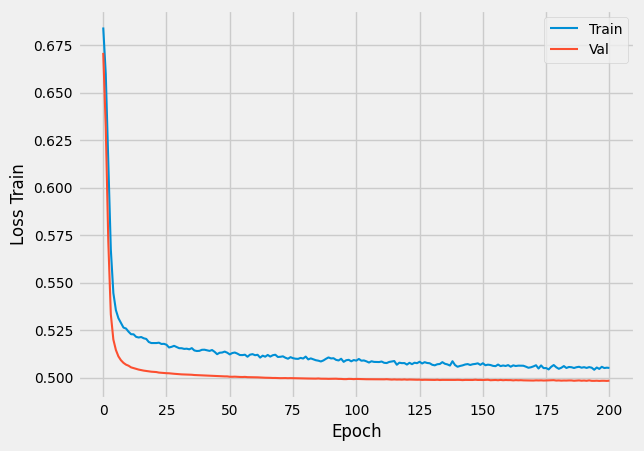

In [23]:

plt.plot(history["TL"], label="Train")
plt.plot(history["VL"], label="Val")
plt.xlabel('Epoch')
plt.ylabel('Loss Train')
plt.legend()
plt.show()

In [27]:
#Train
with torch.no_grad():
    output_train = testeo(X_train)
y_hat_train = output_train.numpy()
y_hat_train = [np.argmax(i) for i in y_hat_train]
print(f'Training Accuracy: {accuracy_score(y_train, y_hat_train):.2f}')
#Testeo
with torch.no_grad():
    output = testeo(X_test)  
y_hat = output.numpy()
y_hat = [np.argmax(i) for i in y_hat]
print(f'Testing Accuracy: {accuracy_score(y_test, y_hat):.2f}')

Training Accuracy: 0.75
Testing Accuracy: 0.75


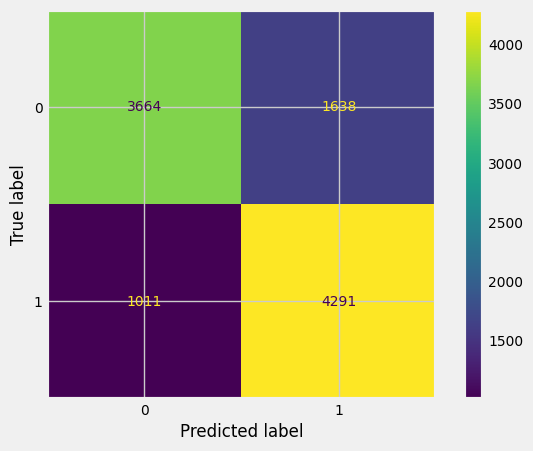

In [28]:
cm =confusion_matrix(y_test, y_hat)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()
plt.show()

In [ ]:
cat_cols = ["Gender", "Smoker", "Diabetic", "Heart_Disease"]
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

IndexError: too many indices for tensor of dimension 2

In [34]:
cols = ['Age', 'BMI', 'Daily_Steps', 'Calories_Intake', 'Hours_of_Sleep', 'Estado_Salud']
sns.pairplot(data[cols], hue='Estado_Salud', diag_kind='kde', corner=True)
plt.show()

KeyError: "['Daily_Steps', 'Calories_Intake', 'Hours_of_Sleep', 'Estado_Salud'] not in index"